In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
forecasting = 20

In [4]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [5]:
df = df['Resistance']
df

0      0.259
1      0.260
2      0.259
3      0.259
4      0.259
       ...  
254    0.301
255    0.301
256    0.302
257    0.300
258    0.296
Name: Resistance, Length: 259, dtype: float64

<AxesSubplot:>

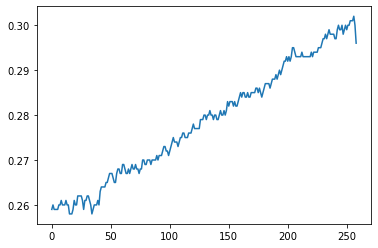

In [6]:
df.plot()

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [8]:
train = df_scaled

In [9]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [10]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [11]:
x_train.shape

(191, 20, 1)

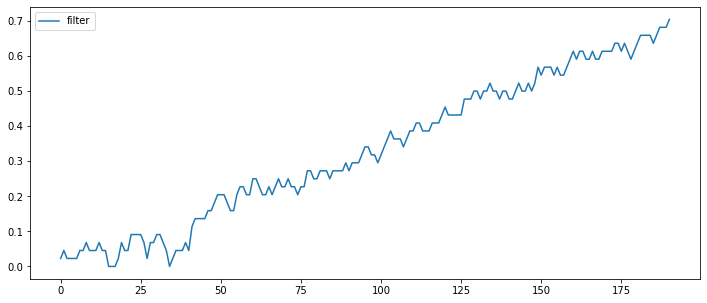

In [12]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

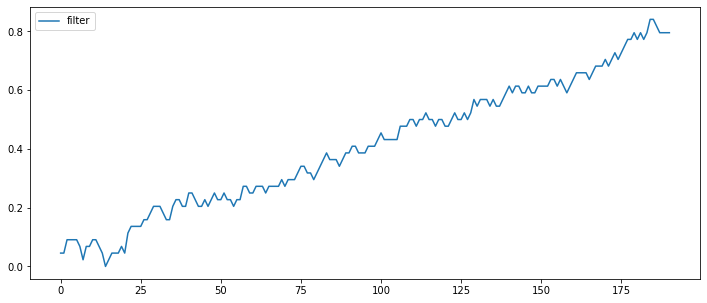

In [13]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [14]:
OUT_STEPS = 20

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [16]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=800, 
                    batch_size=16)

Epoch 1/800
12/12 [==============================] - 2s 4ms/step - loss: 0.1513 - mean_absolute_error: 0.3275
Epoch 2/800
12/12 [==============================] - 0s 5ms/step - loss: 0.1331 - mean_absolute_error: 0.3029
Epoch 3/800
12/12 [==============================] - 0s 5ms/step - loss: 0.1032 - mean_absolute_error: 0.2612
Epoch 4/800
12/12 [==============================] - 0s 5ms/step - loss: 0.0458 - mean_absolute_error: 0.1586
Epoch 5/800
12/12 [==============================] - 0s 4ms/step - loss: 0.0205 - mean_absolute_error: 0.1070
Epoch 6/800
12/12 [==============================] - 0s 4ms/step - loss: 0.0087 - mean_absolute_error: 0.0732
Epoch 7/800
12/12 [==============================] - 0s 4ms/step - loss: 0.0041 - mean_absolute_error: 0.0492
Epoch 8/800
12/12 [==============================] - 0s 4ms/step - loss: 0.0031 - mean_absolute_error: 0.0432
Epoch 9/800
12/12 [==============================] - 0s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0399
Epoch 10/8

12/12 [==============================] - 0s 4ms/step - loss: 6.5708e-04 - mean_absolute_error: 0.0201
Epoch 74/800
12/12 [==============================] - 0s 5ms/step - loss: 5.3797e-04 - mean_absolute_error: 0.0181
Epoch 75/800
12/12 [==============================] - 0s 4ms/step - loss: 5.4018e-04 - mean_absolute_error: 0.0183
Epoch 76/800
12/12 [==============================] - 0s 4ms/step - loss: 5.9825e-04 - mean_absolute_error: 0.0190
Epoch 77/800
12/12 [==============================] - 0s 4ms/step - loss: 5.2144e-04 - mean_absolute_error: 0.0182
Epoch 78/800
12/12 [==============================] - 0s 4ms/step - loss: 5.4962e-04 - mean_absolute_error: 0.0186
Epoch 79/800
12/12 [==============================] - 0s 4ms/step - loss: 5.4468e-04 - mean_absolute_error: 0.0184
Epoch 80/800
12/12 [==============================] - 0s 4ms/step - loss: 5.5894e-04 - mean_absolute_error: 0.0184
Epoch 81/800
12/12 [==============================] - 0s 5ms/step - loss: 6.0949e-04 - mean_a

12/12 [==============================] - 0s 4ms/step - loss: 4.9198e-04 - mean_absolute_error: 0.0176
Epoch 144/800
12/12 [==============================] - 0s 4ms/step - loss: 5.3293e-04 - mean_absolute_error: 0.0183
Epoch 145/800
12/12 [==============================] - 0s 4ms/step - loss: 4.9934e-04 - mean_absolute_error: 0.0176
Epoch 146/800
12/12 [==============================] - 0s 4ms/step - loss: 5.0638e-04 - mean_absolute_error: 0.0178
Epoch 147/800
12/12 [==============================] - 0s 4ms/step - loss: 5.0680e-04 - mean_absolute_error: 0.0178
Epoch 148/800
12/12 [==============================] - 0s 4ms/step - loss: 4.5109e-04 - mean_absolute_error: 0.0168
Epoch 149/800
12/12 [==============================] - 0s 4ms/step - loss: 5.2282e-04 - mean_absolute_error: 0.0181
Epoch 150/800
12/12 [==============================] - ETA: 0s - loss: 4.9210e-04 - mean_absolute_error: 0.016 - 0s 4ms/step - loss: 4.7620e-04 - mean_absolute_error: 0.0172
Epoch 151/800
12/12 [=======

12/12 [==============================] - 0s 4ms/step - loss: 3.9505e-04 - mean_absolute_error: 0.0159
Epoch 213/800
12/12 [==============================] - 0s 4ms/step - loss: 3.9815e-04 - mean_absolute_error: 0.0160
Epoch 214/800
12/12 [==============================] - 0s 4ms/step - loss: 4.1170e-04 - mean_absolute_error: 0.0162
Epoch 215/800
12/12 [==============================] - 0s 4ms/step - loss: 3.8809e-04 - mean_absolute_error: 0.0158
Epoch 216/800
12/12 [==============================] - 0s 4ms/step - loss: 3.8965e-04 - mean_absolute_error: 0.0158
Epoch 217/800
12/12 [==============================] - 0s 4ms/step - loss: 4.0440e-04 - mean_absolute_error: 0.0160
Epoch 218/800
12/12 [==============================] - 0s 4ms/step - loss: 3.9987e-04 - mean_absolute_error: 0.0160
Epoch 219/800
12/12 [==============================] - 0s 5ms/step - loss: 3.9980e-04 - mean_absolute_error: 0.0160
Epoch 220/800
12/12 [==============================] - 0s 4ms/step - loss: 4.2702e-04 

12/12 [==============================] - 0s 4ms/step - loss: 3.7735e-04 - mean_absolute_error: 0.0155
Epoch 283/800
12/12 [==============================] - 0s 4ms/step - loss: 3.5076e-04 - mean_absolute_error: 0.0149
Epoch 284/800
12/12 [==============================] - 0s 4ms/step - loss: 3.4959e-04 - mean_absolute_error: 0.0150
Epoch 285/800
12/12 [==============================] - 0s 4ms/step - loss: 3.5860e-04 - mean_absolute_error: 0.0151
Epoch 286/800
12/12 [==============================] - 0s 4ms/step - loss: 3.6634e-04 - mean_absolute_error: 0.0153
Epoch 287/800
12/12 [==============================] - 0s 4ms/step - loss: 3.9160e-04 - mean_absolute_error: 0.0158
Epoch 288/800
12/12 [==============================] - 0s 4ms/step - loss: 3.6050e-04 - mean_absolute_error: 0.0151
Epoch 289/800
12/12 [==============================] - 0s 4ms/step - loss: 3.4431e-04 - mean_absolute_error: 0.0148
Epoch 290/800
12/12 [==============================] - 0s 4ms/step - loss: 3.7889e-04 

12/12 [==============================] - 0s 4ms/step - loss: 3.3854e-04 - mean_absolute_error: 0.0147
Epoch 353/800
12/12 [==============================] - 0s 4ms/step - loss: 3.3356e-04 - mean_absolute_error: 0.0146
Epoch 354/800
12/12 [==============================] - 0s 4ms/step - loss: 3.4652e-04 - mean_absolute_error: 0.0149
Epoch 355/800
12/12 [==============================] - 0s 4ms/step - loss: 3.2724e-04 - mean_absolute_error: 0.0145
Epoch 356/800
12/12 [==============================] - 0s 4ms/step - loss: 3.3808e-04 - mean_absolute_error: 0.0147
Epoch 357/800
12/12 [==============================] - 0s 4ms/step - loss: 3.2943e-04 - mean_absolute_error: 0.0145
Epoch 358/800
12/12 [==============================] - 0s 4ms/step - loss: 3.4460e-04 - mean_absolute_error: 0.0147
Epoch 359/800
12/12 [==============================] - 0s 4ms/step - loss: 3.4727e-04 - mean_absolute_error: 0.0148
Epoch 360/800
12/12 [==============================] - 0s 5ms/step - loss: 3.4555e-04 

12/12 [==============================] - 0s 4ms/step - loss: 3.2337e-04 - mean_absolute_error: 0.0143
Epoch 423/800
12/12 [==============================] - 0s 4ms/step - loss: 3.0550e-04 - mean_absolute_error: 0.0139
Epoch 424/800
12/12 [==============================] - 0s 5ms/step - loss: 3.1656e-04 - mean_absolute_error: 0.0143
Epoch 425/800
12/12 [==============================] - 0s 4ms/step - loss: 3.1845e-04 - mean_absolute_error: 0.0142
Epoch 426/800
12/12 [==============================] - 0s 4ms/step - loss: 3.2685e-04 - mean_absolute_error: 0.0144
Epoch 427/800
12/12 [==============================] - 0s 4ms/step - loss: 3.1336e-04 - mean_absolute_error: 0.0142
Epoch 428/800
12/12 [==============================] - 0s 4ms/step - loss: 3.1857e-04 - mean_absolute_error: 0.0142
Epoch 429/800
12/12 [==============================] - 0s 4ms/step - loss: 3.1414e-04 - mean_absolute_error: 0.0141
Epoch 430/800
12/12 [==============================] - 0s 4ms/step - loss: 3.0920e-04 

12/12 [==============================] - 0s 4ms/step - loss: 2.9719e-04 - mean_absolute_error: 0.0138
Epoch 493/800
12/12 [==============================] - 0s 4ms/step - loss: 3.0145e-04 - mean_absolute_error: 0.0138
Epoch 494/800
12/12 [==============================] - 0s 4ms/step - loss: 3.2880e-04 - mean_absolute_error: 0.0143
Epoch 495/800
12/12 [==============================] - 0s 4ms/step - loss: 3.8791e-04 - mean_absolute_error: 0.0156
Epoch 496/800
12/12 [==============================] - 0s 4ms/step - loss: 4.3181e-04 - mean_absolute_error: 0.0164
Epoch 497/800
12/12 [==============================] - 0s 4ms/step - loss: 4.0262e-04 - mean_absolute_error: 0.0159
Epoch 498/800
12/12 [==============================] - 0s 4ms/step - loss: 3.9767e-04 - mean_absolute_error: 0.0159
Epoch 499/800
12/12 [==============================] - 0s 4ms/step - loss: 3.4265e-04 - mean_absolute_error: 0.0148
Epoch 500/800
12/12 [==============================] - 0s 4ms/step - loss: 3.1090e-04 

12/12 [==============================] - 0s 4ms/step - loss: 3.0291e-04 - mean_absolute_error: 0.0139
Epoch 563/800
12/12 [==============================] - 0s 5ms/step - loss: 3.0009e-04 - mean_absolute_error: 0.0138
Epoch 564/800
12/12 [==============================] - 0s 4ms/step - loss: 2.8253e-04 - mean_absolute_error: 0.0134
Epoch 565/800
12/12 [==============================] - 0s 5ms/step - loss: 2.8761e-04 - mean_absolute_error: 0.0136
Epoch 566/800
12/12 [==============================] - 0s 4ms/step - loss: 2.8653e-04 - mean_absolute_error: 0.0134
Epoch 567/800
12/12 [==============================] - 0s 4ms/step - loss: 2.8883e-04 - mean_absolute_error: 0.0135
Epoch 568/800
12/12 [==============================] - 0s 4ms/step - loss: 2.8236e-04 - mean_absolute_error: 0.0134
Epoch 569/800
12/12 [==============================] - 0s 4ms/step - loss: 2.9407e-04 - mean_absolute_error: 0.0136
Epoch 570/800
12/12 [==============================] - 0s 4ms/step - loss: 2.9403e-04 

12/12 [==============================] - 0s 5ms/step - loss: 2.8955e-04 - mean_absolute_error: 0.0136
Epoch 633/800
12/12 [==============================] - 0s 5ms/step - loss: 2.8954e-04 - mean_absolute_error: 0.0136
Epoch 634/800
12/12 [==============================] - 0s 5ms/step - loss: 2.8812e-04 - mean_absolute_error: 0.0135
Epoch 635/800
12/12 [==============================] - 0s 5ms/step - loss: 2.7545e-04 - mean_absolute_error: 0.0132
Epoch 636/800
12/12 [==============================] - 0s 4ms/step - loss: 2.7452e-04 - mean_absolute_error: 0.0133
Epoch 637/800
12/12 [==============================] - 0s 5ms/step - loss: 2.8849e-04 - mean_absolute_error: 0.0136
Epoch 638/800
12/12 [==============================] - 0s 4ms/step - loss: 2.7854e-04 - mean_absolute_error: 0.0133
Epoch 639/800
12/12 [==============================] - 0s 5ms/step - loss: 2.8464e-04 - mean_absolute_error: 0.0135
Epoch 640/800
12/12 [==============================] - 0s 5ms/step - loss: 2.8017e-04 

12/12 [==============================] - 0s 4ms/step - loss: 2.6480e-04 - mean_absolute_error: 0.0129
Epoch 702/800
12/12 [==============================] - 0s 4ms/step - loss: 2.7889e-04 - mean_absolute_error: 0.0133
Epoch 703/800
12/12 [==============================] - 0s 4ms/step - loss: 2.7479e-04 - mean_absolute_error: 0.0133
Epoch 704/800
12/12 [==============================] - 0s 4ms/step - loss: 2.7091e-04 - mean_absolute_error: 0.0132
Epoch 705/800
12/12 [==============================] - 0s 4ms/step - loss: 2.7506e-04 - mean_absolute_error: 0.0132
Epoch 706/800
12/12 [==============================] - 0s 4ms/step - loss: 2.5793e-04 - mean_absolute_error: 0.0129
Epoch 707/800
12/12 [==============================] - 0s 4ms/step - loss: 2.7521e-04 - mean_absolute_error: 0.0132
Epoch 708/800
12/12 [==============================] - 0s 5ms/step - loss: 2.7253e-04 - mean_absolute_error: 0.0132
Epoch 709/800
12/12 [==============================] - 0s 4ms/step - loss: 2.7575e-04 

12/12 [==============================] - 0s 4ms/step - loss: 2.7267e-04 - mean_absolute_error: 0.0132
Epoch 772/800
12/12 [==============================] - 0s 4ms/step - loss: 2.7003e-04 - mean_absolute_error: 0.0131
Epoch 773/800
12/12 [==============================] - 0s 4ms/step - loss: 2.7110e-04 - mean_absolute_error: 0.0131
Epoch 774/800
12/12 [==============================] - 0s 4ms/step - loss: 2.5190e-04 - mean_absolute_error: 0.0127
Epoch 775/800
12/12 [==============================] - 0s 4ms/step - loss: 2.6482e-04 - mean_absolute_error: 0.0130
Epoch 776/800
12/12 [==============================] - 0s 5ms/step - loss: 2.5879e-04 - mean_absolute_error: 0.0128
Epoch 777/800
12/12 [==============================] - 0s 5ms/step - loss: 2.6952e-04 - mean_absolute_error: 0.0131
Epoch 778/800
12/12 [==============================] - 0s 5ms/step - loss: 2.5735e-04 - mean_absolute_error: 0.0128
Epoch 779/800
12/12 [==============================] - 0s 5ms/step - loss: 2.6905e-04 

num 0 3.4685012896855363 actual 0.7389162561576352 prediction 0.71328694
num 1 2.8269887362655806 actual 0.7487684729064039 prediction 0.7276009
num 2 2.0207581956401675 actual 0.7536945812807878 prediction 0.73846424
num 3 2.1685581315647138 actual 0.7586206896551722 prediction 0.74216956
num 4 1.4316473251733959 actual 0.7684729064039408 prediction 0.7574711
num 5 1.2262536461945621 actual 0.7733990147783252 prediction 0.7639152
num 6 2.5693628606916628 actual 0.7783251231527091 prediction 0.7583271
num 7 1.711368560790993 actual 0.7832512315270934 prediction 0.7698469
num 8 0.18884278833865178 actual 0.7881773399014778 prediction 0.7866889
num 9 0.9409702342489452 actual 0.7931034482758621 prediction 0.8005663
num 10 0.39940538965621675 actual 0.798029556650246 prediction 0.7948422
num 11 0.6699504675688956 actual 0.798029556650246 prediction 0.80337596
num 12 0.7795186667907408 actual 0.8078817733990147 prediction 0.8015842
num 13 2.758771573711985 actual 0.8226600985221673 predict

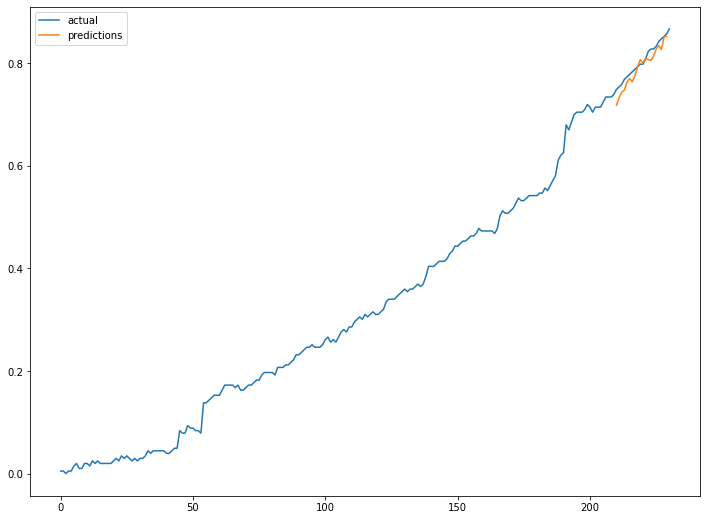

In [17]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 6.312311620128377 actual 0.8006535947712417 prediction 0.75011384
num 1 5.488583445549012 actual 0.8104575163398693 prediction 0.7659749
num 2 3.65229672696217 actual 0.8137254901960784 prediction 0.7840058
num 3 3.0485708236694316 actual 0.8169934640522876 prediction 0.79208684
num 4 1.00789427757263 actual 0.8169934640522876 prediction 0.80875903
num 5 0.21548698622867266 actual 0.8202614379084967 prediction 0.822029
num 6 1.4518572878931761 actual 0.826797385620915 prediction 0.81479347
num 7 1.4974438585340877 actual 0.8366013071895424 prediction 0.8240737
num 8 0.4059742316316136 actual 0.8464052287581698 prediction 0.8498414
num 9 1.7849967397492679 actual 0.8529411764705881 prediction 0.86816615
num 10 0.6165923727782314 actual 0.8594771241830064 prediction 0.85417765
num 11 0.24577677249906382 actual 0.8627450980392155 prediction 0.8606247
num 12 2.0748116385261755 actual 0.8660130718954246 prediction 0.84804493
num 13 3.120437523104089 actual 0.8660130718954246 predictio

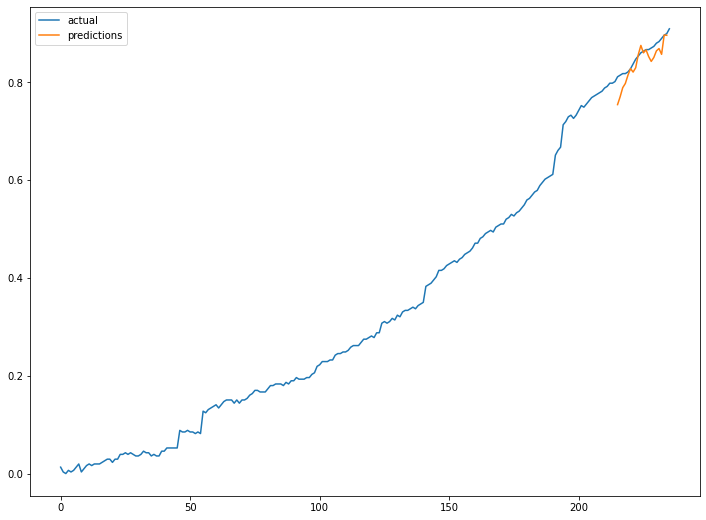

In [18]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 8.206768219287653 actual 0.6190476190476186 prediction 0.6698514
num 1 2.904406189918609 actual 0.6666666666666661 prediction 0.6860294
num 2 4.296249151229756 actual 0.7142857142857135 prediction 0.6835982
num 3 11.750817298889258 actual 0.7619047619047628 prediction 0.6723747
num 4 3.873642683029072 actual 0.7142857142857135 prediction 0.68661684
num 5 0.9351551532746258 actual 0.6666666666666661 prediction 0.67290103
num 6 0.930464267730625 actual 0.6666666666666661 prediction 0.6604636
num 7 2.2525310516358332 actual 0.6666666666666661 prediction 0.68168354
num 8 4.9465560913084925 actual 0.7142857142857135 prediction 0.6789532
num 9 3.956071138381856 actual 0.7142857142857135 prediction 0.68602806
num 10 3.4291148185728955 actual 0.7142857142857135 prediction 0.68979204
num 11 6.5774768590928065 actual 0.6666666666666661 prediction 0.7105165
num 12 2.040886878967394 actual 0.7142857142857135 prediction 0.7288635
num 13 1.1040501296521332 actual 0.7619047619047628 prediction 

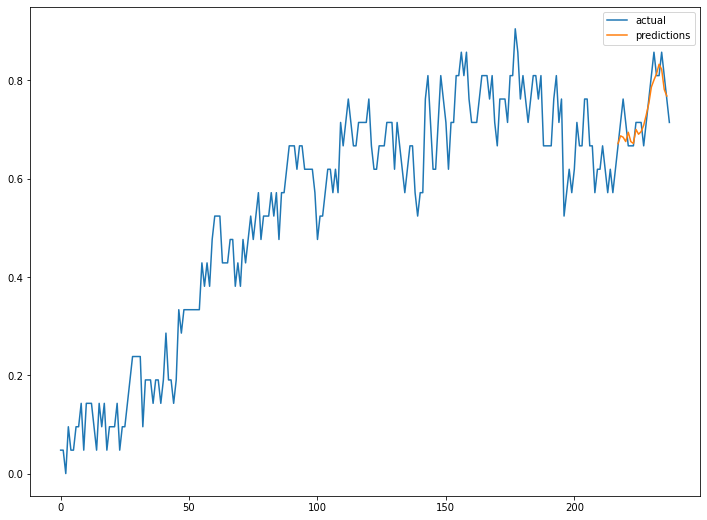

In [19]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

214
(235, 20, 1)
num 0 1.4303122938369601 actual 0.6762402088772845 prediction 0.66656786
num 1 1.7208750049273018 actual 0.6892950391644908 prediction 0.67743313
num 2 1.552351784616795 actual 0.6971279373368144 prediction 0.68630606
num 3 1.6214525832562425 actual 0.702349869451697 prediction 0.6909616
num 4 0.30671122769146336 actual 0.7075718015665795 prediction 0.7054016
num 5 0.2677956854339964 actual 0.7154046997389034 prediction 0.7134889
num 6 2.243581958996349 actual 0.7284595300261096 prediction 0.71211594
num 7 2.0107206523207846 actual 0.7389033942558747 prediction 0.7240461
num 8 1.3553002362467084 actual 0.7493472584856395 prediction 0.73919135
num 9 0.21311384996326854 actual 0.7545691906005221 prediction 0.7529611
num 10 1.7005130292612456 actual 0.7650130548302871 prediction 0.7520039
num 11 0.7091224801783736 actual 0.7676240208877285 prediction 0.7621806
num 12 0.02581807626348749 actual 0.7676240208877285 prediction 0.76742584
num 13 1.2117836499374046 actual 0.778

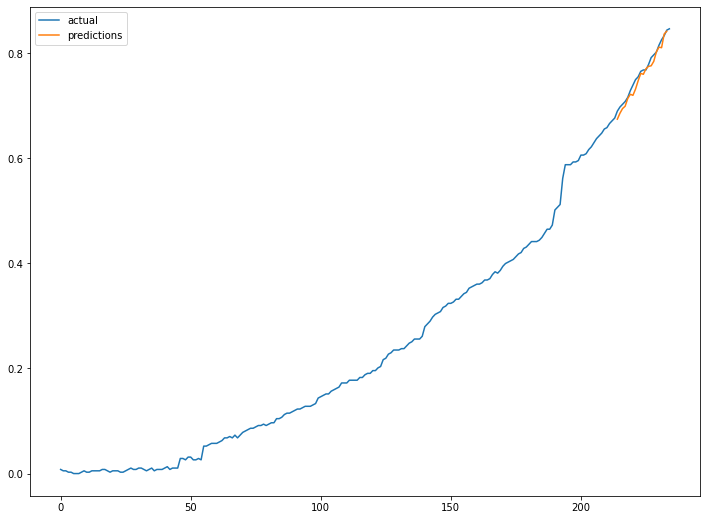

In [20]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

print(plot_len)
print(train_feature2.shape)

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 9.54787103753334 actual 0.7916666666666661 prediction 0.71607935
num 1 8.449456566258412 actual 0.7916666666666661 prediction 0.72477514
num 2 5.369904166773675 actual 0.7916666666666661 prediction 0.7491549
num 3 3.209996223449707 actual 0.75 prediction 0.774075
num 4 1.4178577222322921 actual 0.7916666666666661 prediction 0.8028914
num 5 9.924038251241047 actual 0.75 prediction 0.8244303
num 6 1.8319463729857675 actual 0.8333333333333339 prediction 0.84859955
num 7 4.586596488952562 actual 0.8333333333333339 prediction 0.871555
num 8 2.704100175337295 actual 0.9166666666666661 prediction 0.8918791
num 9 4.03674374455997 actual 0.9583333333333339 prediction 0.9196479
num 10 3.070750443831794 actual 0.9583333333333339 prediction 0.9289053
num 11 2.312977417655673 actual 0.9583333333333339 prediction 0.9361673
num 12 1.8217646557352425 actual 0.9583333333333339 prediction 0.94087476
num 13 1.2004686438519632 actual 0.9583333333333339 prediction 0.94682884
num 14 4.7064889561046925

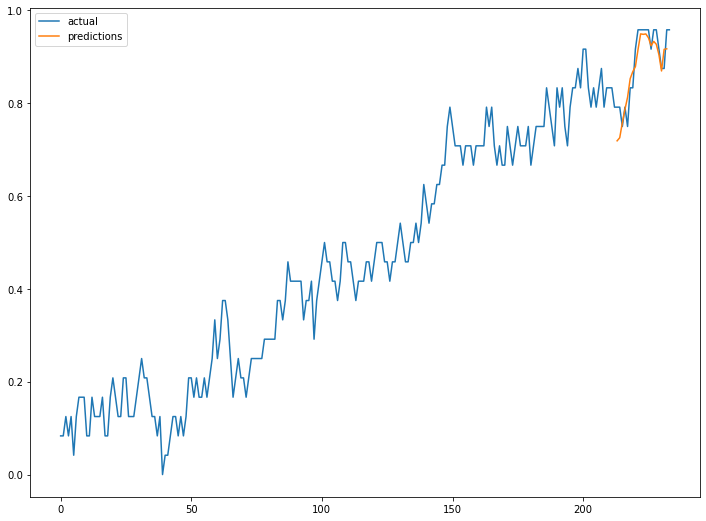

In [21]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 8.181553890830578 actual 0.8482142857142856 prediction 0.7788172
num 1 6.988504528999287 actual 0.8571428571428568 prediction 0.7972414
num 2 3.1855713693719014 actual 0.8482142857142856 prediction 0.8211938
num 3 2.454089619102249 actual 0.8526785714285712 prediction 0.8317531
num 4 1.9543854231686721 actual 0.8660714285714284 prediction 0.84914505
num 5 1.1343955993652344 actual 0.875 prediction 0.86507404
num 6 2.6600832866533013 actual 0.8794642857142856 prediction 0.8560698
num 7 2.7286912927675067 actual 0.8883928571428568 prediction 0.86415136
num 8 1.361930731571111 actual 0.8839285714285712 prediction 0.89596707
num 9 3.1703440987285503 actual 0.8883928571428568 prediction 0.91655797
num 10 1.2459552649295982 actual 0.8839285714285712 prediction 0.8949419
num 11 0.7596225738525462 actual 0.8928571428571428 prediction 0.8996395
num 12 2.654416490309275 actual 0.901785714285714 prediction 0.87784857
num 13 4.613271252862338 actual 0.90625 prediction 0.8644422
num 14 3.6385

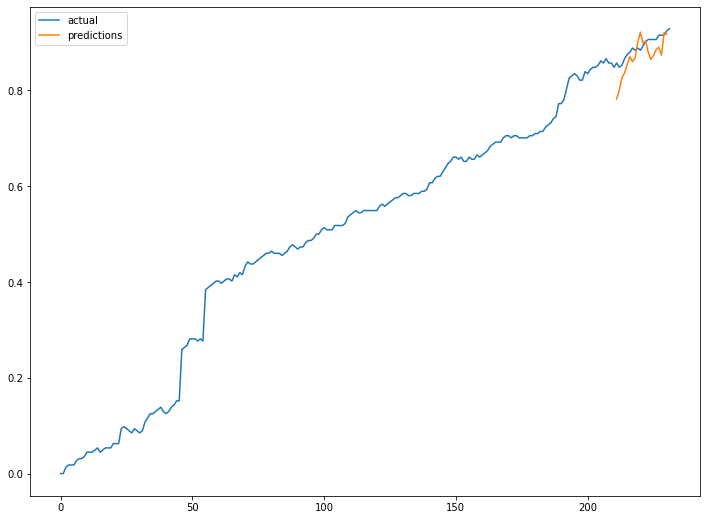

In [22]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 14.889342644635512 actual 0.8500000000000014 prediction 0.7234406
num 1 6.5632969141007305 actual 0.8000000000000007 prediction 0.7474936
num 2 0.2730925877888998 actual 0.75 prediction 0.7479518
num 3 2.48865286509196 actual 0.75 prediction 0.7313351
num 4 0.703112284342448 actual 0.75 prediction 0.74472666
num 5 3.4133116404215493 actual 0.75 prediction 0.72440016
num 6 0.3902469362529861 actual 0.7000000000000011 prediction 0.7027317
num 7 2.4378793580189915 actual 0.7000000000000011 prediction 0.71706516
num 8 9.391212463378846 actual 0.6500000000000004 prediction 0.7110429
num 9 1.0830317224773502 actual 0.7000000000000011 prediction 0.7075812
num 10 5.877931912740072 actual 0.75 prediction 0.7059155
num 11 5.275297164916992 actual 0.75 prediction 0.7104353
num 12 1.0956849370682402 actual 0.7000000000000011 prediction 0.7076698
num 13 2.6573181152342187 actual 0.7000000000000011 prediction 0.7186012
num 14 9.152783453464588 actual 0.8000000000000007 prediction 0.72677773
nu

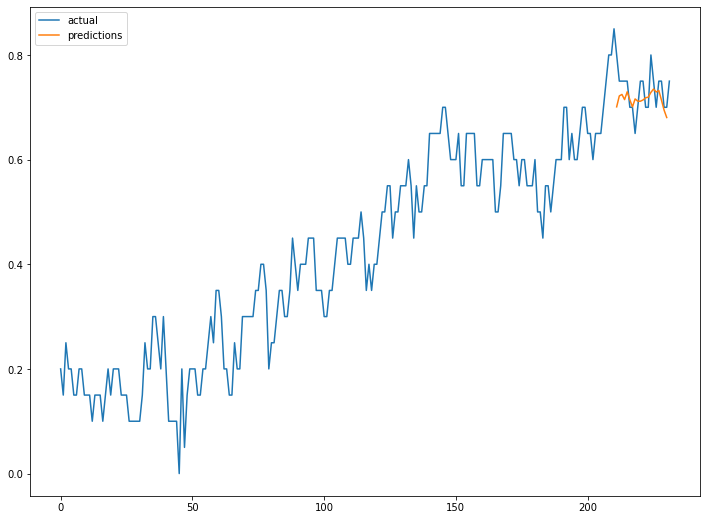

In [23]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 14.889342644635512 actual 0.8500000000000014 prediction 0.7234406
num 1 6.5632969141007305 actual 0.8000000000000007 prediction 0.7474936
num 2 0.2730925877888998 actual 0.75 prediction 0.7479518
num 3 2.48865286509196 actual 0.75 prediction 0.7313351
num 4 0.703112284342448 actual 0.75 prediction 0.74472666
num 5 3.4133116404215493 actual 0.75 prediction 0.72440016
num 6 0.3902469362529861 actual 0.7000000000000011 prediction 0.7027317
num 7 2.4378793580189915 actual 0.7000000000000011 prediction 0.71706516
num 8 9.391212463378846 actual 0.6500000000000004 prediction 0.7110429
num 9 1.0830317224773502 actual 0.7000000000000011 prediction 0.7075812
num 10 5.877931912740072 actual 0.75 prediction 0.7059155
num 11 5.275297164916992 actual 0.75 prediction 0.7104353
num 12 1.0956849370682402 actual 0.7000000000000011 prediction 0.7076698
num 13 2.6573181152342187 actual 0.7000000000000011 prediction 0.7186012
num 14 9.152783453464588 actual 0.8000000000000007 prediction 0.72677773
nu

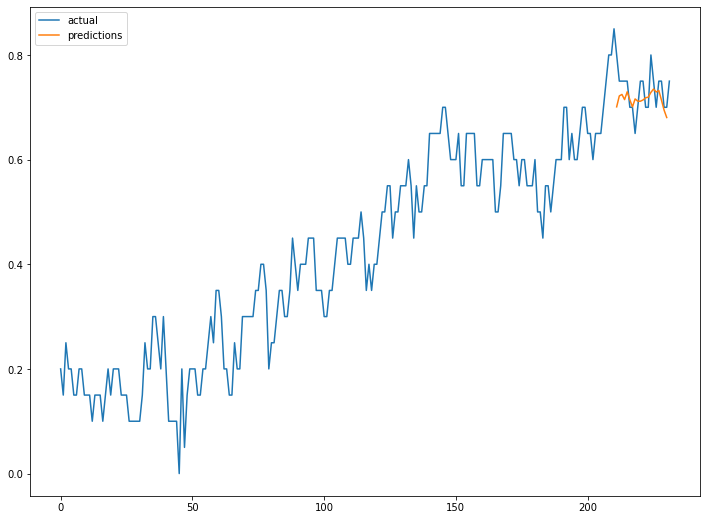

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 6.863246113061801 actual 0.8421052631578938 prediction 0.7843095
num 1 7.191688725442577 actual 0.8684210526315788 prediction 0.8059669
num 2 2.555175870656859 actual 0.8421052631578938 prediction 0.820588
num 3 5.812173901182213 actual 0.8684210526315788 prediction 0.8179469
num 4 4.063268863793555 actual 0.8684210526315788 prediction 0.8331348
num 5 0.5704194307326166 actual 0.8421052631578938 prediction 0.83730173
num 6 0.4911580393390302 actual 0.8157894736842097 prediction 0.81178266
num 7 0.7102074161653577 actual 0.8157894736842097 prediction 0.8215833
num 8 0.2657037228346984 actual 0.8421052631578938 prediction 0.84434277
num 9 2.102351933717841 actual 0.8421052631578938 prediction 0.8598093
num 10 3.6058740182356193 actual 0.8684210526315788 prediction 0.8371069
num 11 0.9800773113967108 actual 0.8421052631578938 prediction 0.85035855
num 12 6.758338563582441 actual 0.8947368421052628 prediction 0.8342675
num 13 4.425651376897618 actual 0.8684210526315788 prediction 0.8

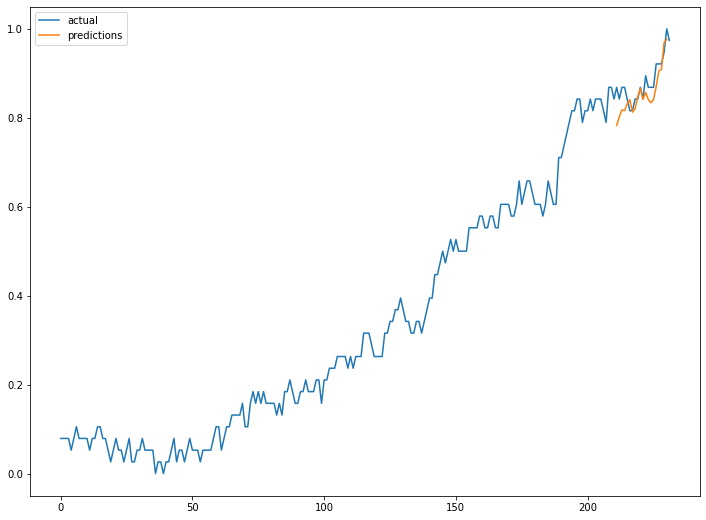

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 7.952343821525671 actual 0.76923076923077 prediction 0.7080589
num 1 1.344710902163986 actual 0.7307692307692317 prediction 0.7209425
num 2 0.021147727966177678 actual 0.7307692307692317 prediction 0.7309238
num 3 0.6427244136206666 actual 0.7307692307692317 prediction 0.73546606
num 4 8.142166667514484 actual 0.6923076923076916 prediction 0.74867654
num 5 1.1119925975800615 actual 0.76923076923077 prediction 0.760677
num 6 6.539868173145191 actual 0.8076923076923084 prediction 0.7548703
num 7 5.927344730922234 actual 0.8076923076923084 prediction 0.7598176
num 8 7.372746142474147 actual 0.8461538461538467 prediction 0.7837691
num 9 0.907710620335254 actual 0.8076923076923084 prediction 0.8003608
num 10 2.6325589418410162 actual 0.76923076923077 prediction 0.7894812
num 11 3.52214515209187 actual 0.76923076923077 prediction 0.7963242
num 12 2.959116101264844 actual 0.76923076923077 prediction 0.7919932
num 13 3.243744940984899 actual 0.8076923076923084 prediction 0.7814928
num 14

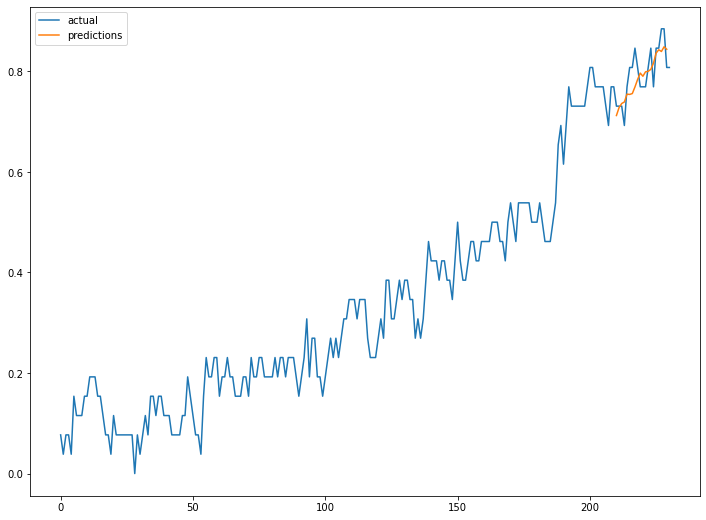

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()